In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = False  ### if the Net isn't originally mapped -> False
rgb = False
mod_init = False
act_fun = nn.LeakyReLU
loader_path = './model_optim_110.pt'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

spada e scuda


In [3]:
class UnlabeledTest(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        with os.scandir(img_dir) as dir:
            for file in dir:
                self.data.append(file.name)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx])
        image = Image.open(img_path).convert('L')
        if self.transform: image = self.transform(image)
        return image, int(self.data[idx][:-4])
    
    def __len__(self):
        return len(self.data)

In [4]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


In [5]:
NDS = UnlabeledTest('../data/unl_test', transform)
test_loader = DataLoader(NDS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

model = GalaxyNet(act_fun, initialization=mod_init, mappy=mappy, is_rgb=rgb).to(device)
loader = torch.load(loader_path, weights_only=True)
model.load_state_dict(loader['model_state_dict'])

tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs, GalaxyID = vdata
            inputs = inputs.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID, outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)

Convs output size: 2


157it [03:37,  1.38s/it]


In [6]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)
display(train_results.groupby('train_label').size())

train_label
A            149
E0         19670
E3         22600
E6          4576
S0a_eon     5507
SAa            2
SAb         2982
SAc         7704
SAd           50
SBb         1184
SBc         1086
SBd            8
Scd_eon     2177
SoA        10544
SoB         1736
dtype: int64

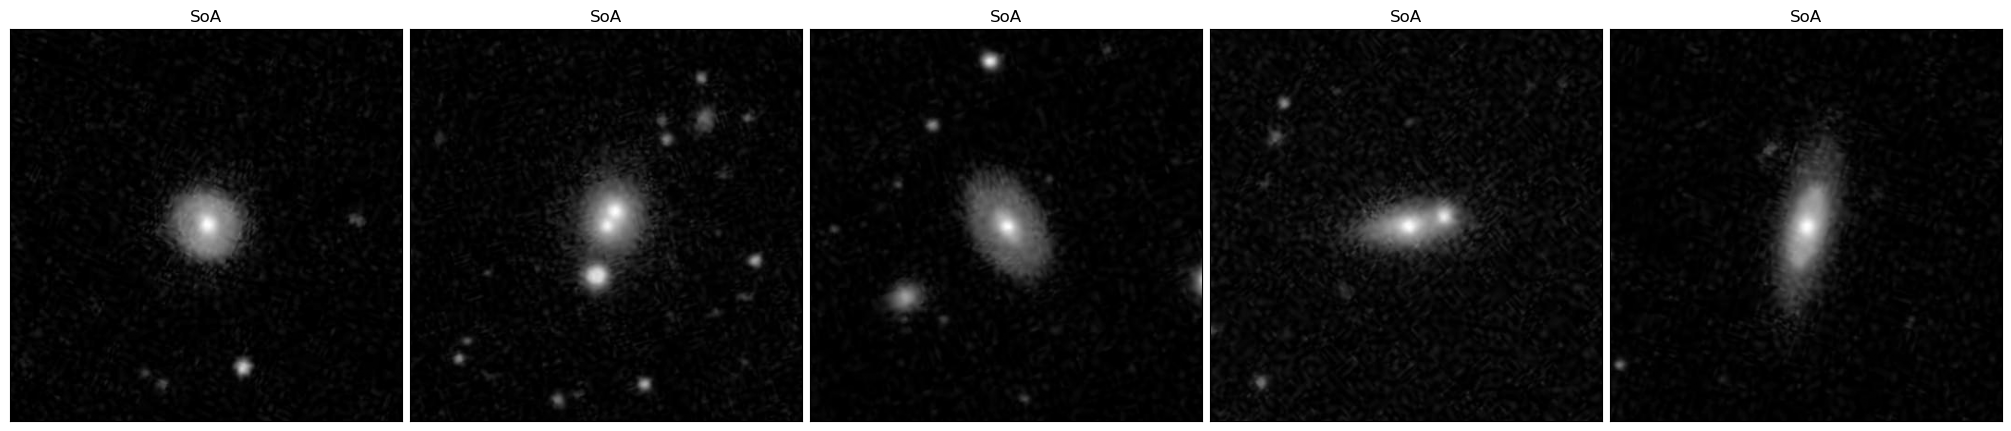

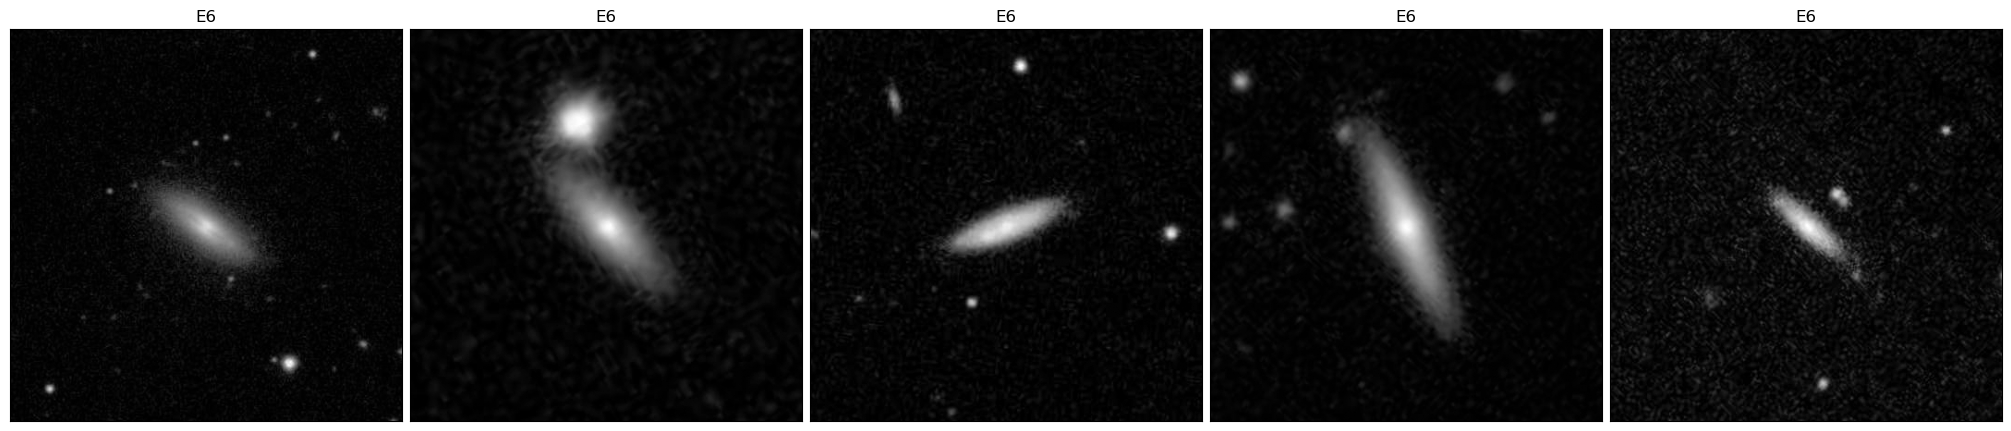

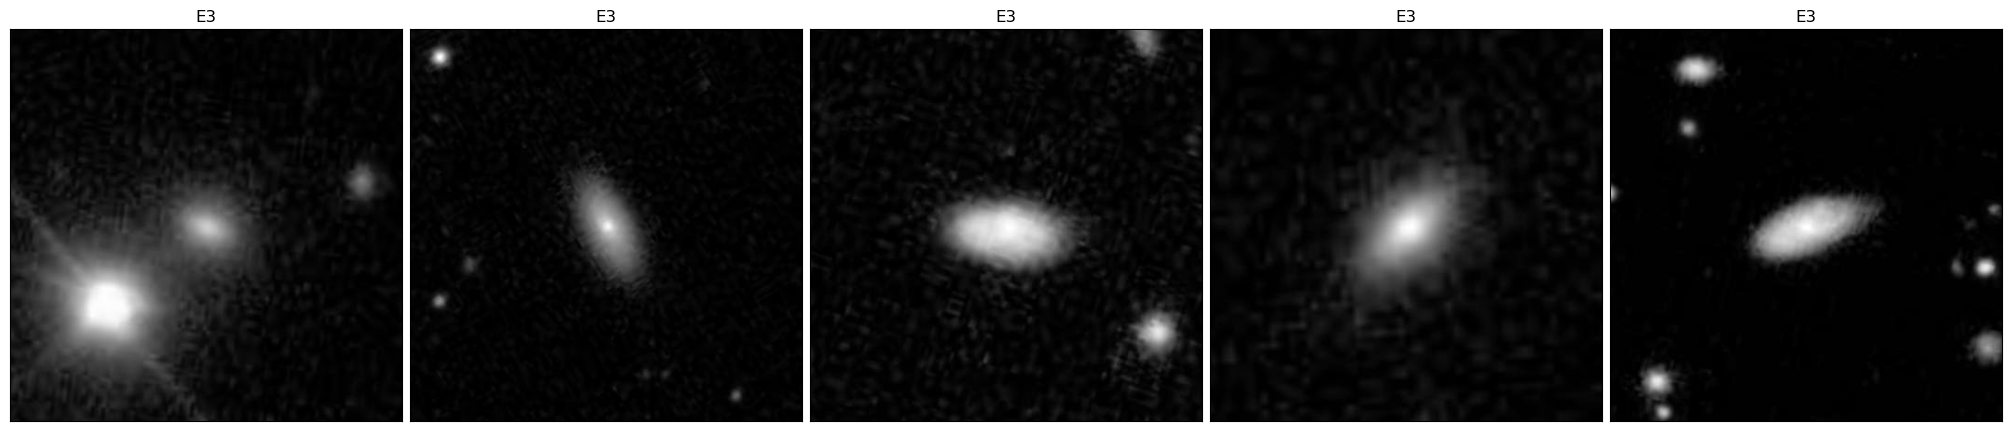

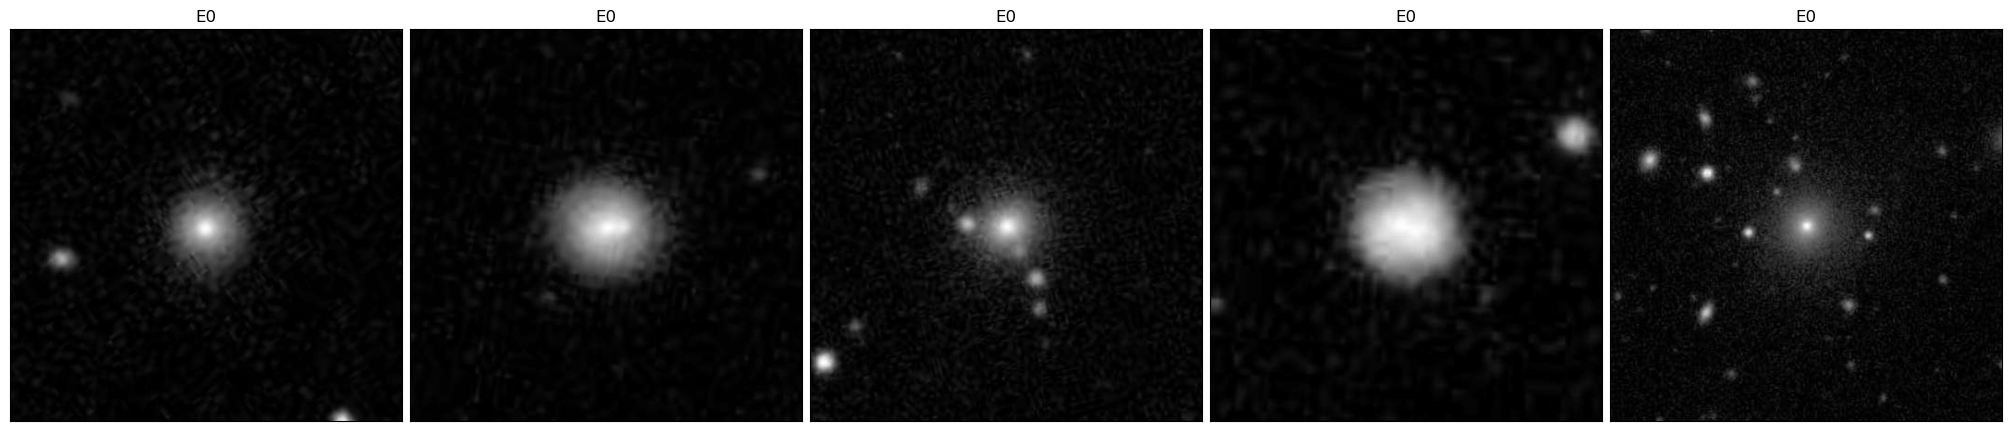

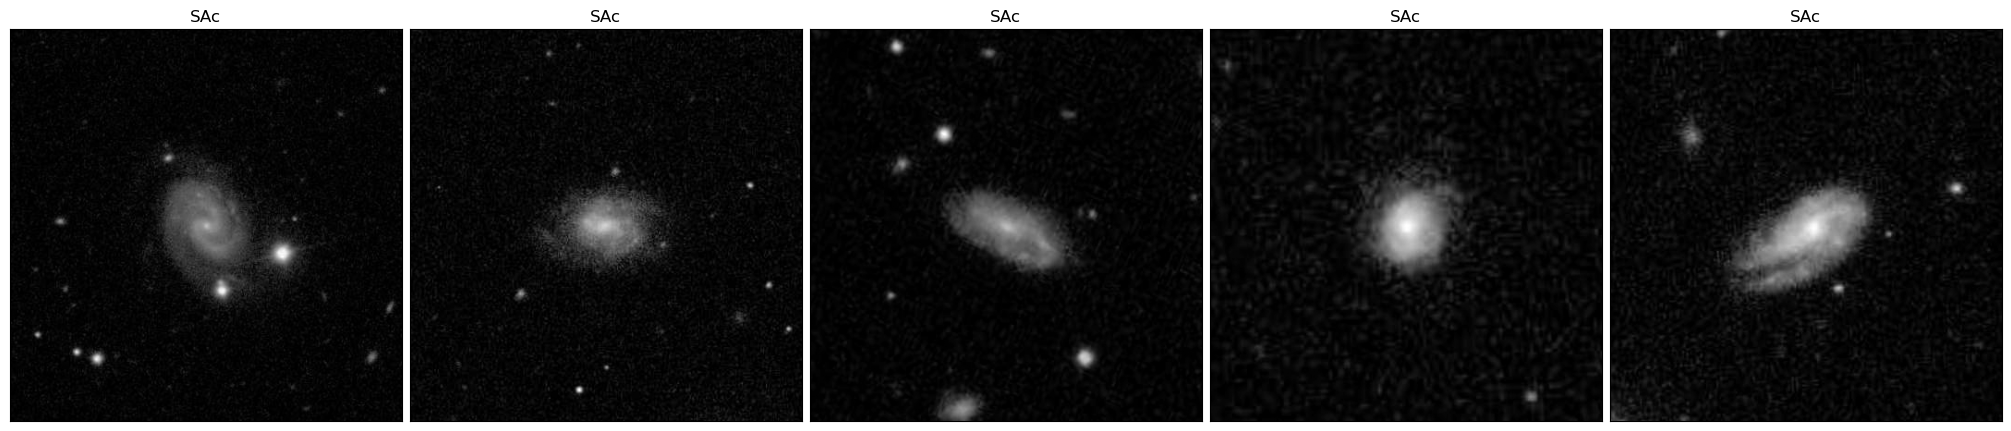

In [11]:
gal_type = ['SoA', 'E6', 'E3', 'E0', 'SAc']
gal_num = 5
ids = []
for id in gal_type: ids.append(train_results[train_results['train_label'] == id].sample(gal_num)['GalaxyID'].to_numpy())

for j, Type in enumerate(gal_type):
    fig, Ax = plt.subplots(1, gal_num, figsize=(20, 8), layout='constrained')
    for i, ax in enumerate(Ax):
        ax.set_aspect('equal', 'box')
        ax.imshow(Image.open('../data/unl_test/' +  str(ids[j][i]) + '.jpg').convert('L'), cmap='gray')
        ax.set_title(Type)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()